# PART WHERE DATA HAPPENS 

In [17]:
import os
import torch
from scipy.io.wavfile import read
import matplotlib.pyplot as plt


In [18]:
base_paths = [
    '../data/music_data/VBB_DRUM_HITS/VBB_KICKS/',
    '../data/music_data/SOPHIE_sample_library/SOPHIE_one_shots/SOPHIE_drums/SOPHIE_kicks/all_kicks',
    '../data/music_data/Drums/Kicks',
    ]

In [19]:
class Dataset:
    def __init__(self, path):
        self.filepaths = self._get_filepaths(path)
        self._len = len(self.filepaths)

    def __getitem__(self, idx):
        _, signal = read(self.filepaths[idx])
        signal = torch.tensor(signal, )
        return signal

    def __len__(self):
        return self._len

    def _get_filepaths(self, path):
        filenames = os.listdir(path)

        filepaths = [os.path.join(path, fn) for fn in filenames]
        return filepaths 

In [20]:
ds = Dataset(base_paths[2]) 

torch.Size([23975, 2])


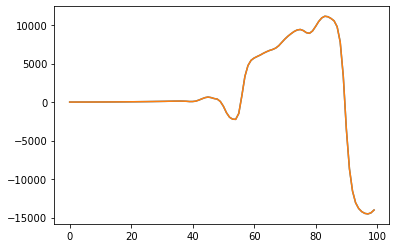

torch.Size([28619, 2])


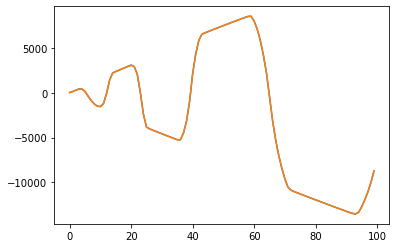

In [21]:
for i in range(2):
    print(ds[i].shape)
    plt.figure()
    plt.plot(ds[i][:100])
    plt.show()

Parts:
+ Practice, How to use autocorrelation.
- Theory, what is autocorrlation and how it works.
- Example, Train model with autocorrelation on some dataset.

In [83]:
from types import SimpleNamespace
cfg = {
    'd_model':2,
    'n_heads':1,
    'batch_size':1,
    'seq_len':100,
}
cfg = SimpleNamespace(**cfg)

In [23]:
import torch
import torch.nn as nn

my_dummy_data = torch.rand(cfg.batch_size, cfg.seq_len, cfg.d_model)
my_dummy_data.shape

torch.Size([1, 20, 2])

In [24]:
from layers import AutoCorrelationLayer, AutoCorrelation

class SmalModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        auto_correletion = AutoCorrelation(
            factor=1, # used for top_k prediction thing
            attention_dropout=0.05,
            output_attention=True,

            scale=None, # does nothing (never used)
            mask_flag=True, # does nothing (never used)
        )

        self.autocorr_layer = AutoCorrelationLayer(
            correlation=auto_correletion,
            d_model=cfg.d_model,
            n_heads=cfg.n_heads,
            d_keys=None) # Why we not use it? who knows
    
    def forward(self, x, attn_mask=None):
        x = self.autocorr_layer(x,x,x, attn_mask)
        return x

In [84]:
data = ds[0][:cfg.seq_len].unsqueeze(0).float() #/ 10000
data.shape

torch.Size([1, 100, 2])

In [85]:
model = SmalModel(cfg)

In [95]:
from tqdm import tqdm
criterion_mse =  nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), 1e-2)

losses = []
for epoch in tqdm(range(1000)):
    out,_ = model(data)

    loss = criterion_mse(out, data)
    loss.backward()
    opt.step()

    losses += [loss.item()]
    # print(loss.item())

100%|██████████| 1000/1000 [00:02<00:00, 365.86it/s]


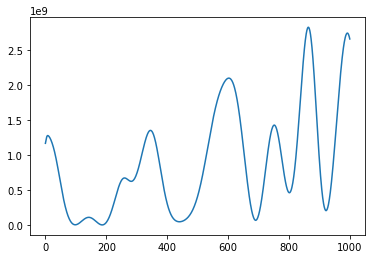

In [98]:
plt.plot(losses)
# plt.yscale('log')

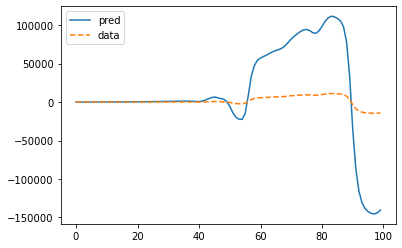

In [99]:
plt.figure()
plt.plot(out.detach()[0][:,0], label='pred')
plt.plot(data[0,:,0], '--', label='data')
plt.legend()
plt.show()
